*March 2020*
Representation and Interaction

## Multiagent search of lost targets 2D in a static world using range sensors

**Author**: Pablo Lanillos Donders Institute

**References**: 
- Lanillos, P. (2013): Minimum time search of moving targets in uncertain environments. Ph.D. Dissertation. url: 
http://www.therobotdecision.com/papers/PhD_MinimumTimeSearch_2013_FinalElectronic_English_PabloLanillos.pdf

*Continuous*
- Lanillos, P., Gan, S. K., Besada-Portas, E., Pajares, G., & Sukkarieh, S. (2014). Multi-UAV target search using decentralized gradient-based negotiation with expected observation. Information Sciences, 282, 92-110.

*Discrete*
- Lanillos, P., Besada-Portas, E., Pajares, G., & Ruz, J. J. (2012, October). Minimum time search for lost targets using cross entropy optimization. In 2012 IEEE/RSJ International Conference on Intelligent Robots and Systems (pp. 602-609). IEEE.

All references can be found in Brightspace

### A small introduction tale
There  is  no  doubt, I  have lost my keys again, I’m late and I don’t know where to start the search. I evaluate the alternatives.  I usually leave them at the entrance hall, hanging from that screw that I put in a provisional eternal way.  They can also be in the bedroom, inside the Cairo bowl or inside the jeans pocket, which I have used yesterday.  Rationally, the most coherent action is to look first at the hall, but in the case that the keys are not there, I have to come back and that is a great time-wasting.  I only have ten minutes left to pick up the high speed train to Barcelona.  Therefore, I finally decide to watch in the bowl first and afterwards inside the jeans, and if I don’t find them I will look at the screw, which is on my way out. 
<img src="img/irritated-man-on-a-train.png" width="200" style="float: right;" />



Already  heading  Barcelona,  inside  the  train  and  without  the  keys,  I  think  about  my decision.  I really don’t know if my searching strategy has been optimal. Served with a coffee at the dining car, I write down the different options that I had this morning to prove that I have made the correct decision.  The problem started with the subjective information about the keys location: high  probability  of  finding  them  at  the  hall  and  medium  probability  of  finding  them in  the  jeans  and  the  bowl.   If  I  can  quantify  that  information,  the  only  thing  I  have to  determine  is  which  searching  path  is  the  best.   Thus,  I  need  the  actions  sequence that gives maximum probability of finding the keys, which is the same to look for the sequence that gives minimum probability of not finding them.  I raise my gaze and I take pleasure of my own explanation.  

The train car is getting full of people, maybe because it is lunch time. I stare again at my sheet full of hieroglyph and I continue engrossed in my task.  After doing some math, I check that ordering the places from greater to less probability and visiting them according to that order could be the best strategy. While I bite my green pen with anxiety, I discover that the method doesn’t always work and more questions arrive without an answer:  What happens if the time is critical? What if we are several people? And what about if already choosing a decision the alternatives change?...  But the fact that make me  feel  unease  is  to  think  that  even  making  the  right  decisions,  why  haven’t I found the keys? Once in  my  seat,  with  the  eyes  wide  shut  and  a  little  bit  sleepy,  I  receive  a  message on my cellphone that says:  - *remember that I took the keys to water the plants. When you come back, please call me.  Kisses* -.

### Description of the problem

<img src="img/problem-definition.png" width="400" style="float: left;" />
There is a shipwreck alert. We need to find the survivors but we do not have so much time. We count with a fleet of Unmanned Air Vehicles (UAVs) with sensors on board. We also have an initial guess of the possible areas where the survivors can be, such as a probability of finding the survivors. For simplicity we are going to do a strong assumption: the location of the survivors is constant. In other words, the world is static or the targets (survivors) do not have dynamics.

**The goal of this assignment is to program an algorithm that let multiple searching agents to find the survivors as soon as possible.** In other words, the algorithm should compute the optimal actions for the UAVs.

<img src="img/shipwreck.png" width="600" />

This document will drive you through the assignment composed of the following sections:

*In this booknote*
1. Modelling the problem: environment, agent and sensor
2. One agent search greedy 1 step discrete

*In the next booknote*
3. Multiagent search greedy 1 step discrete no communication
4. Multiagent search greedy 1 step discrete common belief
5. Multiagent search n-step continuous optimization (centralized)

### Import needed libraries

In [1]:
# Numpy numerical library -> import [library] as name
import numpy as np

# Plotting libraries -> matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D # 3D plots
from matplotlib import cm # Color maps

# Matrix auxiliary functions
import numpy.matlib

# System libraries
import os
import sys
import math

### 1. Modelling the problem: environment, sensor and agents

#### Environment
We model the environment as bounded 2D space of width $w$ and height $h$. The discrete representation of the world can be stored in a matrix that looks like:

<img src="img/map.png" width="400" />


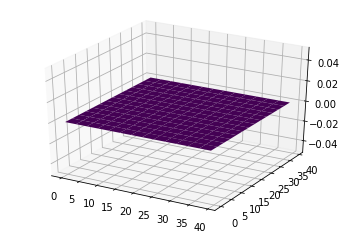

In [2]:
# Plot the discrete environment
from itertools import permutations
width = height = 40 # Size of the environment

x = y = np.arange(width) # This only works if both have the same size
X, Y = np.meshgrid(x, y) # generate grid

map = np.zeros((width,height))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, map, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
# Write your code here for ploting the map using plot_surface (see 1_python_numpy_basics notebook)

#### Sensor
Each agent $i$ has a range sensor on board able to detect people in the sea with probability $p$. The position of the agent  is $x=\{x_i,x_j\}$ (2D location). We are going to model the sensor in a probabilistic fashion. The sensor will return the probability of non-detecting the target. This is due to the utility function that we will see afterwards. Given the euclidean distance between the agent and the potential target location as $d$, the range sensor is modelled by the following equation:

$$p(\overline{D}) = 1 - P_{d_{max}} \exp\left[ -\sigma \left( \frac{d}{d_{max}}\right)^2 \right]$$

Note that we can compute the euclidian distance as $d = \sqrt{ (i-x_i)^2 +(j-x_j)^2}$ and $\exp$ is the exponential operator. 

Program and plot the non-detection sensor model. The plot should looks like this one:
<img src="img/pnd-sensor.png" width="400" />

Note that we can update the belief that the agent has about the world with observations using a Recursive Bayesian Estimator procedure. Here as the world is static we only need the update and not the prediction step.

The update for $N$ observations (N steps ahead) is as follows: 

$$ b^k = \prod_{j=1}^N P(\overline{D}|x^k, \tau) b^{k-1} $$
Where $b^{k-1}$ is our prior belief of the target location $P(\tau)$ and $N$ is the number of observations. Here, we are assuming independence of the measures (observations).

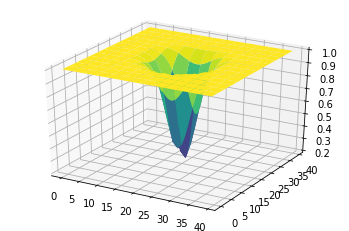

In [3]:
# observation model
Pdmax = 0.8 # Max range sensor
dmax = 4 # Max distance
sigma = 0.7 # Sensor spread (standard deviation)

x = [20,20] # Agent 2D location 
I = X.flatten() # Convert matrix into a single vector useful for operating 
J = Y.flatten() # Convert matrix into a single vector useful for operating 

## Write your code here
# Compute the sensor P(\overline{D}) with a function with name 
# def sensor_pnd( ... ):
def sensor_pnd(pdmax, dmax, sigma, x, i, j):
    d = math.sqrt(math.pow((i - x[0]), 2) + math.pow((j - x[1]), 2))
    pd = pdmax * math.exp(-sigma * math.pow(d/dmax, 2))
    pnd = 1 - pd
    return pnd

# Plot the sensor
map = np.zeros((width, height))
for i in I:
    for list in Y:
        j = list[0]
        distance = sensor_pnd(Pdmax, dmax, sigma, x, i, j)
        map[i][j] = distance

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, map, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

#### Agents
Each agent in the discrete version has its state defined as the 2D location $s$ at time $k$ ($s^k$) and a set of possible actions $u^k$. The grid and the possible actions are defined in the following figure:
<img src="img/actions-discrete.png" width="400" />

In [9]:
ndir = 9 # number of movements
delta = 1.0 # Constant displacement
# Define the 9 possible movements with an array of size(ndir,2) of delta increments
# Example to move up is -delta, 0

# Write your code here
mat = np.array([[-delta, -delta], [-delta, 0.], [-delta, delta], [0., -delta], [0., 0.], [0., delta], [delta, -delta], [delta, 0.], [delta, delta]])

print("Movements", mat)


# Given the state of the agent
x = [20,20] # agent state

# Write a function that computes all next movements or forward states (fs) using the np.random.permutation function 
# We use this randomization to avoid selecting the same action when all actions have the same utility
# Write the code of the function here
# def forward_states( ... ):
# (Remember to remove outside grid (out of bound) movements with a  boolean mask)

def feasible_states(mat, x):
    fs = mat + x
    fs = np.random.permutation(fs)
    feasible = []
    for element in fs:
        if element[0]>=0 and element[0]<width:
            if element[1]>=0 and element[1]<height:
                feasible.append(element)
    return fs, np.array(feasible)

fs, feasible = feasible_states(mat, x)
print('forward states', fs)
print("feasible", feasible)


Movements [[-1. -1.]
 [-1.  0.]
 [-1.  1.]
 [ 0. -1.]
 [ 0.  0.]
 [ 0.  1.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]]
forward states [[20. 19.]
 [20. 21.]
 [21. 19.]
 [19. 21.]
 [21. 21.]
 [21. 20.]
 [20. 20.]
 [19. 20.]
 [19. 19.]]
feasible [[20. 19.]
 [20. 21.]
 [21. 19.]
 [19. 21.]
 [21. 21.]
 [21. 20.]
 [20. 20.]
 [19. 20.]
 [19. 19.]]


### Initial belief (prior information)

Our intel department has computed that the shipwreck is in the middle of our environment: $w/2, h/2$. We model the initial probability of the target location $P(\tau)$ with a bivariate Gaussian distribution $N(\mu, \Sigma)$ like the following:

<img src="img/b0.png" width="400" />


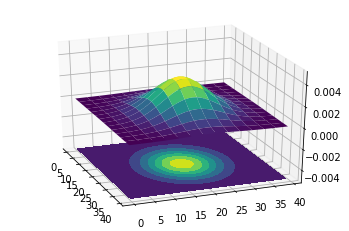

In [11]:
from itertools import product

# Compute the initial prior belief for the agent
w = h = 40 # Size of the world
mu = np.array([w/2., h/2.])# center point
Sigma = np.array([[40,0],[0,60]]) # Bimodal covariance with no dependence.

# Write your code here for computing the bivariate Gaussian function 
# Tip: You should normalize the belief to sum to 1. You can divide the belief by its sum to obtain it
# def bivariate_gaussian( ... ):
def bivariate_gaussian(x, mu, sigma):
    division = 1/math.sqrt((2*math.pi)**2*np.linalg.det(sigma))
    exp = math.exp(np.dot(-0.5*(x - mu).T, np.dot(np.linalg.inv(Sigma), (x-mu))))
    result = division * exp
    return result

# Plot the initial belief
   
beliefs = np.zeros((40,40))
# compute belief for every grid position
for i in range(width):
    for j in range(height):
        beliefs[i,j] = bivariate_gaussian([i,j], mu, Sigma)
        
# normalize beliefs        
beliefs = beliefs/np.sum(beliefs)
beliefs = beliefs.reshape((width, height))

# create environment
x = np.arange(width)
y = np.arange(height)
X, Y = np.meshgrid(x, y)

# plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, beliefs, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
cset = ax.contourf(X, Y, beliefs, zdir='z', offset=-0.005, cmap=cm.viridis)
        
ax.set_zlim(-0.005,0.005)
ax.view_init(27, -21)
plt.show()

### 2. One agent search greedy 1 step discrete

We will program one agent search algorithm with 1-step ahead discrete (greedy). The idea is to select the next state that maximize the utility function: to maximize the probability of finding the target.

**Tip: This is the same as maximizing the (1- probability of not finding the target)**

The algorithm is as follows:
1. Compute the possible next states
2. Compute the utility for each new state
3. Select the maximum utility state $\arg \max$
4. Move the agent and perform an observation
5. Go to step 1

#### Utility function

To evaluate "how good" is a state we compute how much information gain we accumulate we exerting an action. That is, an action $u$ is better if the probability of finding the target $\tau$ is higher than others. As we have deterministic actions: an action always arrives to the same state, we can model the utility function given the state as:

$$ U(x) = \sum_\tau^k p(\overline{D}| x^k,\tau) b_\tau^{k-1}$$

This is the sum over all possible states of $\tau$ (marginalization) of the probability of non-detecting the target given the agent state and the target state.

Solving the problem is minimizing $U(x)$ or we can solve the maximization of $1-U(x)$.

In [12]:
##### Program the utility computation for all possible forward states (using the previous agent code and prior initialization)
# You need to program the utility function and the function that returns the next best state
tau = permutations(np.arange(width), 2)
#def utility( ... ):
# utility takes in an agent state x, possible movements mat and prior beliefs beliefs and returns the utility of state x
def utility(mat, x, beliefs):
    map = np.zeros((width,height))
    for i in range(40):
        for j in range(40):
            map[i,j] = sensor_pnd(Pdmax, dmax, sigma, x, i, j) * beliefs[i,j]
    return sum(sum(map))

#def next_best_state( ... ):
# utility takes in an agent state x, possible movements mat and prior beliefs beliefs 
# and returns the best state to move to from x
def next_best_state(mat, x, beliefs):
    fs, feasible = feasible_states(mat, x)
    utilities = []
    for state in feasible:
        util = utility(mat, state, beliefs)
        utilities.append(util)
    min_index = np.argmin(utilities)
    return feasible[min_index]

x = [0,0]
xf = next_best_state(mat, x, beliefs)
print("best state", xf)

best state [1. 1.]


### Algorithm

Write the full algorithm with a loop. Plot the agent trajectory as well as the belief map as in this figure:

<img src="img/solution.png" width="400" />

-------------------------------------------------

> One agent search 2D (greedy 1-step ahead)

[[0. 0.]
 [1. 1.]
 [1. 0.]
 [0. 1.]]
[0.988331742656864, 0.9881639333442936, 0.9882537302655274, 0.988271604481474]
0
normalization factor:  0.9881639333442936
iteration 0 [1. 1.]


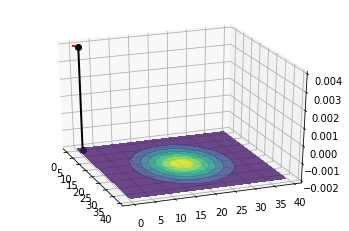

[[1. 2.]
 [0. 2.]
 [2. 1.]
 [2. 2.]
 [0. 1.]
 [1. 1.]
 [2. 0.]
 [0. 0.]
 [1. 0.]]
[0.9996442057071734, 0.9997707875279481, 0.9996108210036696, 0.9994636769952258, 0.9998361483322611, 0.9997436777109974, 0.9997259430676209, 0.999886323187897, 0.9998207803672924]
7
normalization factor:  0.9994636769952258
iteration 1 [2. 2.]


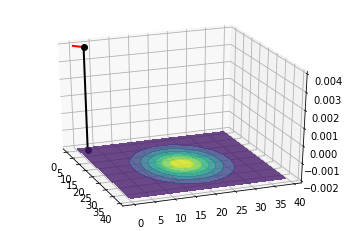

[[2. 3.]
 [2. 2.]
 [1. 3.]
 [3. 2.]
 [3. 3.]
 [1. 1.]
 [1. 2.]
 [2. 1.]
 [3. 1.]]
[0.9994044857444172, 0.9995694416237179, 0.9996142057889331, 0.9993454493069319, 0.9991054551033628, 0.9998083659307724, 0.9997247267305962, 0.9996961736579945, 0.9995325285994581]
5
normalization factor:  0.9991054551033628
iteration 2 [3. 3.]


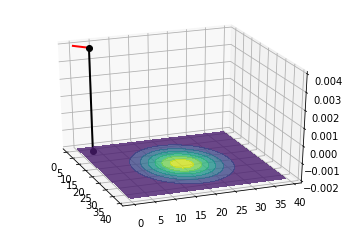

[[3. 3.]
 [3. 2.]
 [2. 3.]
 [2. 2.]
 [4. 4.]
 [2. 4.]
 [4. 3.]
 [4. 2.]
 [3. 4.]]
[0.9992752455796492, 0.9994821396846725, 0.9995327725327838, 0.9996718975066262, 0.9985208752511174, 0.999348072306862, 0.9989058686819379, 0.9992062786953287, 0.9990054564185855]
3
normalization factor:  0.9985208752511174
iteration 3 [4. 4.]


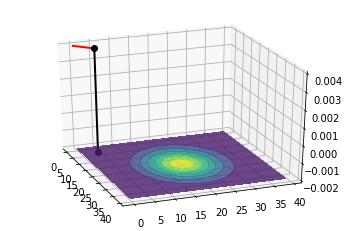

[[3. 4.]
 [4. 5.]
 [5. 5.]
 [3. 3.]
 [3. 5.]
 [5. 4.]
 [4. 3.]
 [4. 4.]
 [5. 3.]]
[0.999219355834175, 0.9983737981302118, 0.9976124346945964, 0.9994459458091569, 0.9989184507671225, 0.9982137234233165, 0.9991339095576051, 0.9988037745915922, 0.9986842535847256]
3
normalization factor:  0.9976124346945964
iteration 4 [5. 5.]


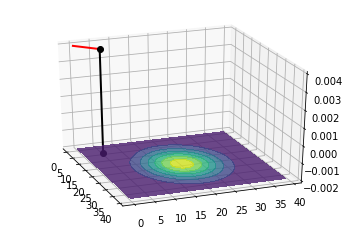

[[5. 4.]
 [6. 4.]
 [5. 6.]
 [5. 5.]
 [4. 6.]
 [6. 5.]
 [4. 5.]
 [4. 4.]
 [6. 6.]]
[0.9985936764333373, 0.9978874594327128, 0.9974178817125241, 0.9980822778805709, 0.9982556639271092, 0.9971725285775699, 0.9987308826409305, 0.9990893307904409, 0.996262233677427]
7
normalization factor:  0.996262233677427
iteration 5 [6. 6.]


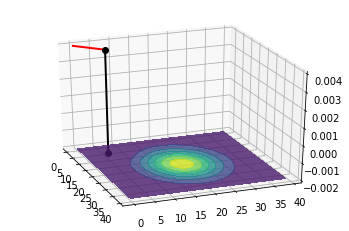

[[7. 6.]
 [5. 6.]
 [7. 5.]
 [6. 6.]
 [5. 7.]
 [6. 5.]
 [5. 5.]
 [7. 7.]
 [6. 7.]]
[0.9956721851587109, 0.9980017410042947, 0.9967236566829554, 0.9970247971129343, 0.997275597180217, 0.9977918139655448, 0.9985508337245259, 0.994338705148648, 0.996031336425978]
6
normalization factor:  0.994338705148648
iteration 6 [7. 7.]


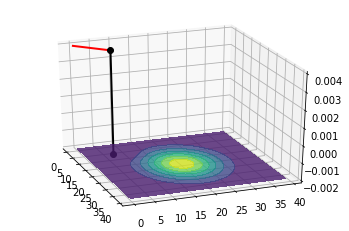

[[8. 6.]
 [7. 7.]
 [6. 7.]
 [7. 6.]
 [6. 6.]
 [8. 8.]
 [7. 8.]
 [8. 7.]
 [6. 8.]]
[0.9950931532615483, 0.9955372172795129, 0.9969568438176643, 0.9966501842751386, 0.9977707303707521, 0.9917082838202816, 0.9941003219986536, 0.993597411887796, 0.9958835874033013]
4
normalization factor:  0.9917082838202816
iteration 7 [8. 8.]


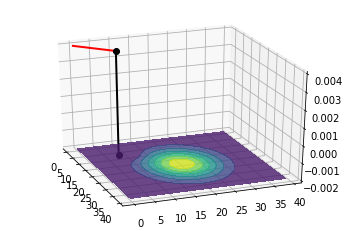

[[9. 9.]
 [7. 9.]
 [8. 8.]
 [7. 8.]
 [9. 8.]
 [9. 7.]
 [8. 9.]
 [8. 7.]
 [7. 7.]]
[0.9882520345465001, 0.9939814653006456, 0.9935256028511208, 0.9955165515248059, 0.9908403914248703, 0.9928979886490226, 0.9915149142103937, 0.9950879516746762, 0.996684049011817]
8
normalization factor:  0.9882520345465001
iteration 8 [9. 9.]


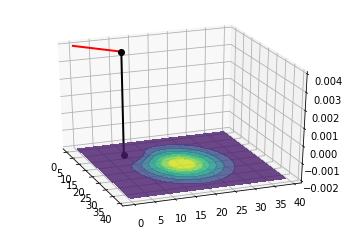

[[10. 10.]
 [ 8. 10.]
 [ 8.  9.]
 [10.  9.]
 [ 9.  9.]
 [ 8.  8.]
 [ 9. 10.]
 [ 9.  8.]
 [10.  8.]]
[0.9838858226460782, 0.9914777627018995, 0.993604132579297, 0.987316897354689, 0.9909076455467689, 0.995225779334682, 0.9881840453593134, 0.9930299936903104, 0.9900543170002266]
5
normalization factor:  0.9838858226460782
iteration 9 [10. 10.]


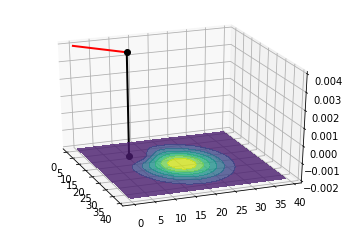

[[11. 10.]
 [10.  9.]
 [ 9. 10.]
 [11.  9.]
 [ 9.  9.]
 [ 9. 11.]
 [10. 10.]
 [11. 11.]
 [10. 11.]]
[0.9829839818684027, 0.9904174069145122, 0.991155342328879, 0.9865069018424365, 0.9933379154367649, 0.9883002984739844, 0.9876261695581723, 0.978581243090329, 0.9840523307634279]
4
normalization factor:  0.978581243090329
iteration 10 [11. 11.]


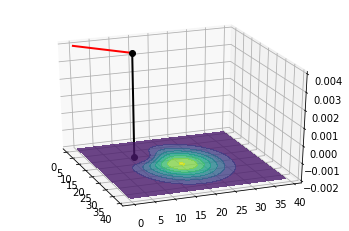

[[12. 11.]
 [11. 12.]
 [10. 10.]
 [11. 10.]
 [12. 10.]
 [11. 11.]
 [12. 12.]
 [10. 11.]
 [10. 12.]]
[0.9778566361886614, 0.9791164823054257, 0.9909778172730787, 0.9872190302713534, 0.9822439063736405, 0.9836630052512593, 0.9723840039374644, 0.9881291852871026, 0.9844097610504374]
2
normalization factor:  0.9723840039374644
iteration 11 [12. 12.]


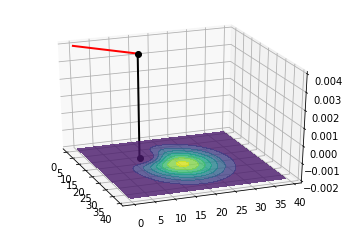

[[12. 13.]
 [13. 13.]
 [13. 11.]
 [13. 12.]
 [11. 11.]
 [12. 11.]
 [11. 13.]
 [12. 12.]
 [11. 12.]]
[0.9734391462788037, 0.965426995780659, 0.9773100192632023, 0.9720210233670875, 0.9881271423371462, 0.9834426740715551, 0.9798128117572428, 0.9790514822513502, 0.9845187533226042]
4
normalization factor:  0.965426995780659
iteration 12 [13. 13.]


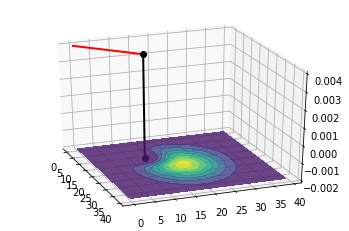

[[14. 14.]
 [14. 13.]
 [12. 13.]
 [13. 12.]
 [13. 14.]
 [12. 14.]
 [13. 13.]
 [12. 12.]
 [14. 12.]]
[0.9579364583675932, 0.9656427048434907, 0.9803612394920591, 0.9791449440657288, 0.9671586988742915, 0.9745735928551629, 0.9738862404773095, 0.9848006562344378, 0.9718164176585968]
7
normalization factor:  0.9579364583675932
iteration 13 [14. 14.]


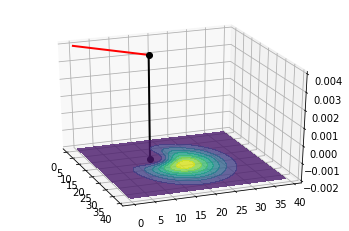

[[14. 14.]
 [14. 15.]
 [13. 14.]
 [14. 13.]
 [13. 15.]
 [15. 15.]
 [13. 13.]
 [15. 13.]
 [15. 14.]]
[0.9683296262262178, 0.9604942833413593, 0.9757465796430776, 0.974438948742513, 0.9688230007720877, 0.9502307720053345, 0.9810544652121944, 0.9659467257879473, 0.9589691606959685]
6
normalization factor:  0.9502307720053345
iteration 14 [15. 15.]


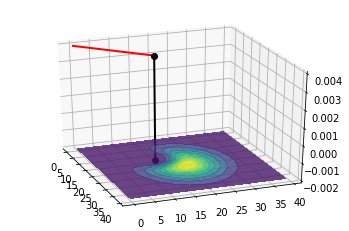

[[14. 16.]
 [16. 14.]
 [15. 15.]
 [16. 16.]
 [15. 14.]
 [16. 15.]
 [14. 15.]
 [15. 16.]
 [14. 14.]]
[0.962765249632199, 0.9599584286364004, 0.9626141723607867, 0.9427118347573938, 0.9694993665471239, 0.9523262657419891, 0.9708243146182409, 0.9537456591751533, 0.9769933344558628]
8
normalization factor:  0.9427118347573938
iteration 15 [16. 16.]


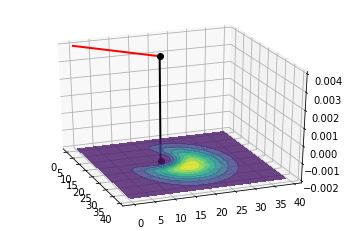

[[15. 16.]
 [17. 17.]
 [16. 16.]
 [15. 15.]
 [17. 15.]
 [15. 17.]
 [17. 16.]
 [16. 15.]
 [16. 17.]]
[0.965807883900114, 0.9358484469406899, 0.9570402423778037, 0.9727764605726145, 0.9541787780962634, 0.956680756340794, 0.9461079204559837, 0.9645639894949564, 0.9472869301004049]
3
normalization factor:  0.9358484469406899
iteration 16 [17. 17.]


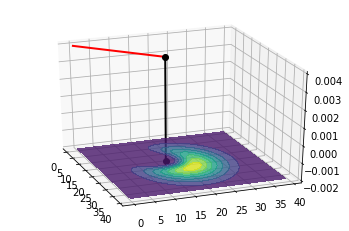

[[16. 18.]
 [17. 18.]
 [16. 16.]
 [18. 18.]
 [17. 16.]
 [18. 16.]
 [16. 17.]
 [18. 17.]
 [17. 17.]]
[0.9509230892898513, 0.9415519326806174, 0.9686201765291015, 0.9301497934586029, 0.9599298423776698, 0.9489930694894434, 0.9609745070809204, 0.9407568350956136, 0.9519668049148269]
2
normalization factor:  0.9301497934586029
iteration 17 [18. 18.]


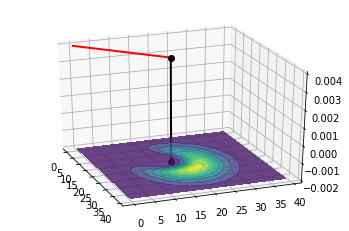

[[17. 19.]
 [19. 18.]
 [19. 19.]
 [19. 17.]
 [18. 17.]
 [18. 18.]
 [17. 17.]
 [18. 19.]
 [17. 18.]]
[0.9459058727664323, 0.9367331249998482, 0.9261257601665206, 0.9448217154245613, 0.9559405407765516, 0.947791857108697, 0.9647946388855534, 0.9370074962365353, 0.9566572217156996]
6
normalization factor:  0.9261257601665206
iteration 18 [19. 19.]


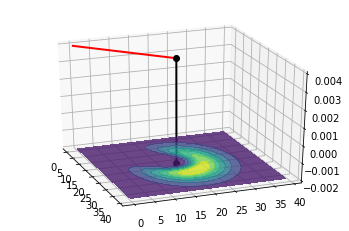

[[19. 20.]
 [20. 18.]
 [20. 20.]
 [18. 19.]
 [19. 18.]
 [20. 19.]
 [19. 19.]
 [18. 20.]
 [18. 18.]]
[0.9341101005872565, 0.9420818620035732, 0.9242308940362614, 0.9532241759379204, 0.952960461122932, 0.9344671334326585, 0.944918180474815, 0.9420739966530662, 0.9616100608822483]
8
normalization factor:  0.9242308940362614
iteration 19 [20. 20.]


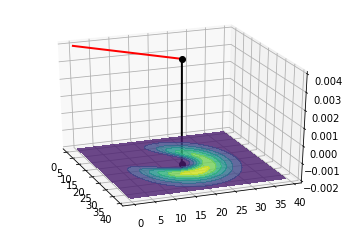

[[21. 21.]
 [19. 20.]
 [20. 19.]
 [19. 19.]
 [20. 21.]
 [20. 20.]
 [19. 21.]
 [21. 19.]
 [21. 20.]]
[0.9247923002030255, 0.9510403313514721, 0.9513320059688277, 0.9593876661078167, 0.9332435589712209, 0.9437015320706406, 0.9398539951070294, 0.9411311144972606, 0.9342955858599322]
3
normalization factor:  0.9247923002030255
iteration 20 [21. 21.]


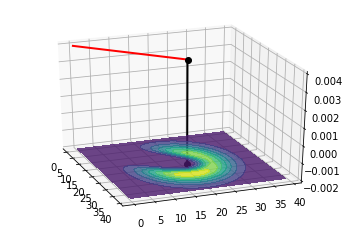

[[21. 22.]
 [21. 20.]
 [21. 21.]
 [20. 20.]
 [20. 22.]
 [22. 20.]
 [22. 21.]
 [22. 22.]
 [20. 21.]]
[0.9346422135826652, 0.9513166163099389, 0.9443839137145671, 0.9584130592603378, 0.9395833835445027, 0.942197117836034, 0.9363874452583694, 0.9279301979535504, 0.9504103446736949]
3
normalization factor:  0.9279301979535504
iteration 21 [22. 22.]


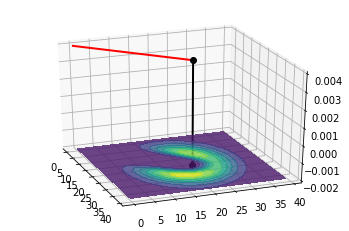

[[22. 23.]
 [23. 21.]
 [21. 22.]
 [21. 23.]
 [23. 23.]
 [22. 21.]
 [21. 21.]
 [22. 22.]
 [23. 22.]]
[0.9383157892664965, 0.945307419959804, 0.9515099548120247, 0.9414294076608271, 0.9334920331729031, 0.9530290763877647, 0.9588766590353092, 0.9470246377546986, 0.9406771100452016]
6
normalization factor:  0.9334920331729031
iteration 22 [23. 23.]


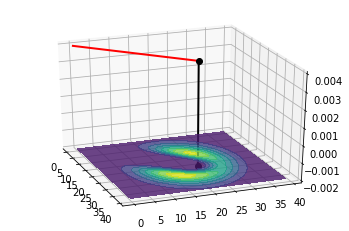

[[24. 23.]
 [23. 24.]
 [24. 22.]
 [22. 23.]
 [24. 24.]
 [22. 24.]
 [23. 22.]
 [22. 22.]
 [23. 23.]]
[0.9468325071206547, 0.944003719581215, 0.9502449876404809, 0.9543248408552971, 0.9410304656852223, 0.9453212483613276, 0.9563854400024613, 0.9608161708345361, 0.9514528441655681]
7
normalization factor:  0.9410304656852223
iteration 23 [24. 24.]


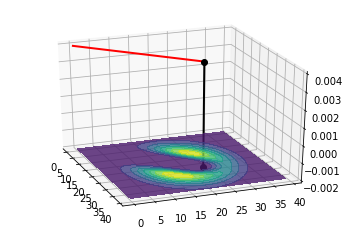

[[25. 24.]
 [25. 23.]
 [25. 25.]
 [23. 24.]
 [24. 25.]
 [23. 23.]
 [24. 24.]
 [23. 25.]
 [24. 23.]]
[0.9542843185084625, 0.9565567454176488, 0.9498514390838793, 0.9586235174216616, 0.9511883664854882, 0.9640840924796029, 0.9572682951680466, 0.950927291502653, 0.9610900725559858]
5
normalization factor:  0.9498514390838793
iteration 24 [25. 25.]


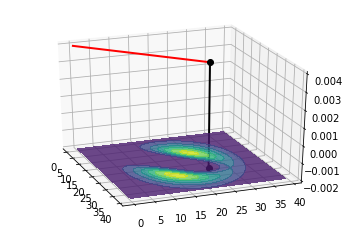

[[26. 26.]
 [24. 25.]
 [24. 24.]
 [26. 25.]
 [25. 26.]
 [24. 26.]
 [25. 24.]
 [25. 25.]
 [26. 24.]]
[0.9591343336265147, 0.9639849819006339, 0.9683604558765078, 0.9623228241441474, 0.9591792805792636, 0.9576997546258914, 0.9666783220334709, 0.9639042418952046, 0.9636272507692623]
2
normalization factor:  0.9576997546258914
iteration 25 [24. 26.]


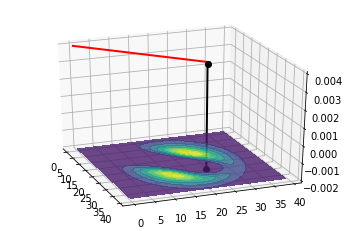

[[25. 26.]
 [23. 25.]
 [25. 27.]
 [23. 26.]
 [24. 27.]
 [24. 25.]
 [25. 25.]
 [23. 27.]
 [24. 26.]]
[0.9693489204158345, 0.9707960665028625, 0.9648313624472328, 0.9649875985178799, 0.9624707588511271, 0.9726577319436213, 0.9723361054049625, 0.9579747085243298, 0.968275934963102]
5
normalization factor:  0.9579747085243298
iteration 26 [23. 27.]


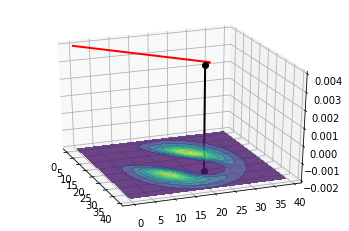

[[24. 28.]
 [22. 26.]
 [23. 27.]
 [24. 26.]
 [23. 28.]
 [22. 27.]
 [22. 28.]
 [23. 26.]
 [24. 27.]]
[0.9671785091085291, 0.9690283375155012, 0.9688809160541532, 0.976154531643144, 0.9630609608685639, 0.9630597165863206, 0.9566026437636996, 0.9738873970409644, 0.9721795470482038]
3
normalization factor:  0.9566026437636996
iteration 27 [22. 28.]


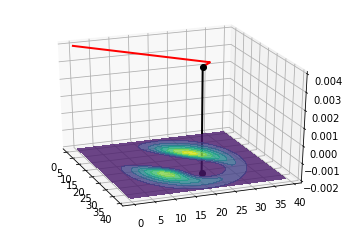

[[23. 29.]
 [23. 27.]
 [21. 28.]
 [22. 27.]
 [22. 28.]
 [23. 28.]
 [22. 29.]
 [21. 27.]
 [21. 29.]]
[0.9687231544799426, 0.9774598445842593, 0.9613376503988538, 0.9731955634161313, 0.968639858641211, 0.9733901561167116, 0.9637276303924942, 0.9662107676848236, 0.9564496161018907]
1
normalization factor:  0.9564496161018907
iteration 28 [21. 29.]


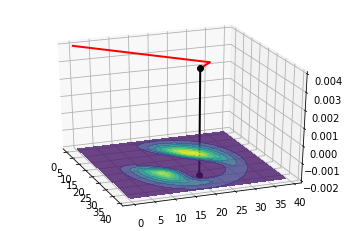

[[22. 28.]
 [21. 28.]
 [21. 29.]
 [20. 28.]
 [20. 29.]
 [20. 30.]
 [22. 30.]
 [21. 30.]
 [22. 29.]]
[0.9778748057726377, 0.9724174733196801, 0.9691344255425248, 0.9643476656705862, 0.9614257574147932, 0.9586100767289925, 0.9707270169843173, 0.9656924011203732, 0.9744760017817535]
0
normalization factor:  0.9586100767289925
iteration 29 [20. 30.]


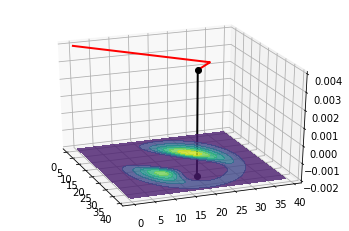

[[21. 29.]
 [21. 30.]
 [19. 31.]
 [20. 29.]
 [20. 31.]
 [21. 31.]
 [19. 30.]
 [19. 29.]
 [20. 30.]]
[0.9784166927733939, 0.9761595374881814, 0.9629896188779222, 0.9725872924017157, 0.9691560533934999, 0.9736081257390373, 0.9637635377214523, 0.9644541576180726, 0.970976616529165]
0
normalization factor:  0.9629896188779222
iteration 30 [19. 31.]


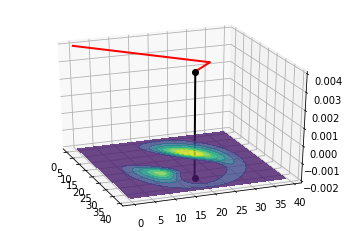

[[20. 32.]
 [18. 31.]
 [19. 32.]
 [19. 31.]
 [20. 31.]
 [18. 32.]
 [19. 30.]
 [20. 30.]
 [18. 30.]]
[0.9772813566957663, 0.9680106483270748, 0.9737500451969205, 0.9741266327307856, 0.9786255055786, 0.9688647095552473, 0.9740914327269027, 0.9795985405162957, 0.9667239951272629]
7
normalization factor:  0.9667239951272629
iteration 31 [18. 30.]


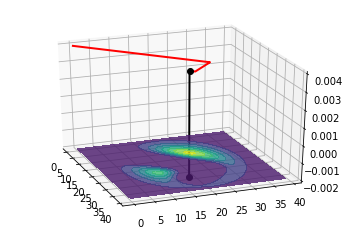

[[18. 29.]
 [18. 31.]
 [17. 30.]
 [17. 29.]
 [19. 29.]
 [18. 30.]
 [17. 31.]
 [19. 31.]
 [19. 30.]]
[0.9743065449822943, 0.9767645330943635, 0.9688788396170224, 0.9660539771444937, 0.9808860959427139, 0.9758689158097396, 0.971034812503888, 0.9811664379258682, 0.9813491492949528]
8
normalization factor:  0.9660539771444937
iteration 32 [17. 29.]


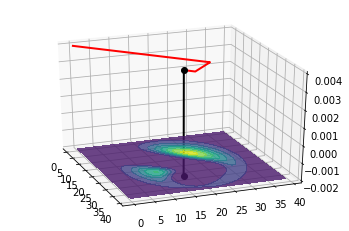

[[16. 28.]
 [18. 28.]
 [17. 30.]
 [18. 29.]
 [16. 30.]
 [17. 29.]
 [16. 29.]
 [17. 28.]
 [18. 30.]]
[0.9647407419909473, 0.9804748961181327, 0.9777332594698188, 0.9819849385874841, 0.9715053145084174, 0.9758480067246151, 0.968455275902688, 0.9732843851193221, 0.9828206676551076]
8
normalization factor:  0.9647407419909473
iteration 33 [16. 28.]


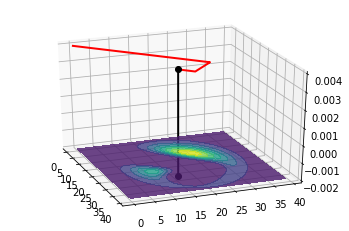

[[17. 27.]
 [16. 28.]
 [15. 29.]
 [15. 28.]
 [16. 27.]
 [17. 28.]
 [15. 27.]
 [16. 29.]
 [17. 29.]]
[0.9799793649075931, 0.9757664159372504, 0.9719034905100817, 0.9685043804403782, 0.9727672654098952, 0.9820635063342239, 0.9645445462052152, 0.9781812899669777, 0.9835588230041046]
8
normalization factor:  0.9645445462052152
iteration 34 [15. 27.]


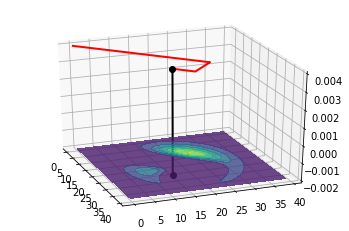

[[16. 26.]
 [16. 28.]
 [15. 28.]
 [15. 27.]
 [14. 28.]
 [16. 27.]
 [14. 27.]
 [15. 26.]
 [14. 26.]]
[0.980207749398147, 0.9841851981500677, 0.9789333729737886, 0.9764445363277136, 0.973013654297864, 0.9824333377835731, 0.9697577541948932, 0.9734880960628074, 0.9660608797040252]
1
normalization factor:  0.9660608797040252
iteration 35 [14. 26.]


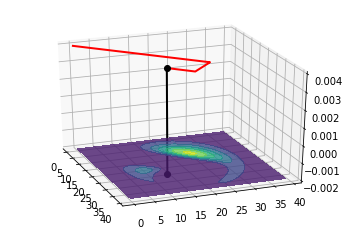

[[13. 27.]
 [14. 26.]
 [14. 27.]
 [15. 25.]
 [13. 26.]
 [15. 27.]
 [13. 25.]
 [14. 25.]
 [15. 26.]]
[0.9750416588920796, 0.9780832548785197, 0.9803089376736682, 0.9813700864907459, 0.9722626853101588, 0.9851066414750248, 0.9691390407310704, 0.9754880886373559, 0.9834248930427837]
5
normalization factor:  0.9691390407310704
iteration 36 [13. 25.]


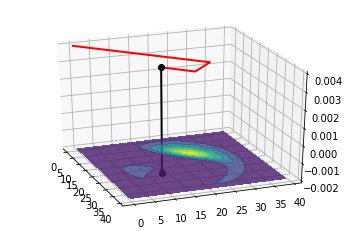

[[13. 24.]
 [14. 25.]
 [12. 26.]
 [14. 24.]
 [13. 25.]
 [12. 24.]
 [13. 26.]
 [14. 26.]
 [12. 25.]]
[0.9784363159857707, 0.9850214581009271, 0.9778434607588322, 0.9833119221760459, 0.9805147425384201, 0.9732724173612922, 0.9822927067657171, 0.9864311102035397, 0.9756979825440767]
7
normalization factor:  0.9732724173612922
iteration 37 [12. 24.]


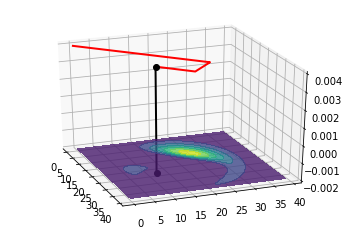

[[11. 24.]
 [13. 25.]
 [11. 23.]
 [12. 25.]
 [12. 23.]
 [13. 23.]
 [12. 24.]
 [13. 24.]
 [11. 25.]]
[0.9796231724043085, 0.988089763661331, 0.977885144935268, 0.9847000760585762, 0.9818904314951288, 0.9857337098640157, 0.9834229597115953, 0.9870371077945085, 0.9811209601130517]
1
normalization factor:  0.977885144935268
iteration 38 [11. 23.]


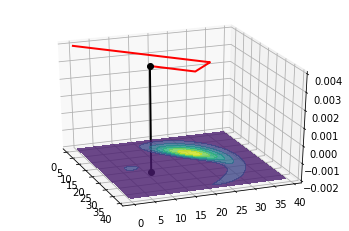

[[12. 24.]
 [11. 24.]
 [11. 22.]
 [10. 23.]
 [12. 22.]
 [12. 23.]
 [10. 24.]
 [10. 22.]
 [11. 23.]]
[0.9899370605171173, 0.9872935664949565, 0.9854420345042454, 0.9836211046743891, 0.9883273633560969, 0.9892408188883155, 0.9845488194743993, 0.9824788137564217, 0.9864802781945553]
0
normalization factor:  0.9824788137564217
iteration 39 [10. 22.]


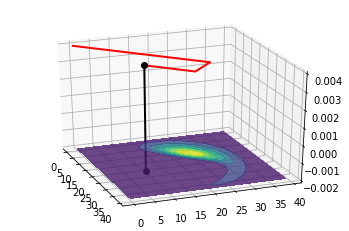

[[ 9. 22.]
 [10. 21.]
 [10. 22.]
 [11. 22.]
 [ 9. 23.]
 [ 9. 21.]
 [11. 23.]
 [10. 23.]
 [11. 21.]]
[0.9873632398209826, 0.9887764760040043, 0.9894135636641282, 0.9914221994048591, 0.9878440216557064, 0.9866880040003132, 0.9918138780870592, 0.9898496205339247, 0.990838868573712]
6
normalization factor:  0.9866880040003132
iteration 40 [ 9. 21.]


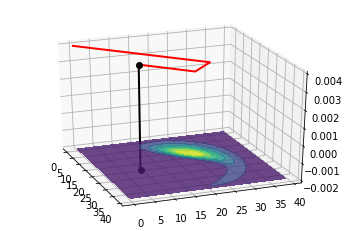

[[ 9. 21.]
 [10. 21.]
 [ 8. 22.]
 [ 8. 20.]
 [ 9. 22.]
 [ 8. 21.]
 [10. 20.]
 [10. 22.]
 [ 9. 20.]]
[0.9920316193434124, 0.9934218219495948, 0.9908012775911818, 0.9902925524981768, 0.9921942525464158, 0.990634236721664, 0.9930911714606905, 0.9935835478366599, 0.991690445037934]
7
normalization factor:  0.9902925524981768
iteration 41 [ 8. 20.]


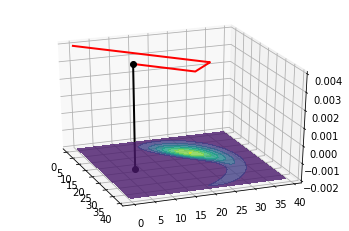

[[ 7. 20.]
 [ 8. 21.]
 [ 7. 21.]
 [ 8. 20.]
 [ 9. 21.]
 [ 8. 19.]
 [ 7. 19.]
 [ 9. 20.]
 [ 9. 19.]]
[0.9933317424969393, 0.9942185834832649, 0.9933049343616858, 0.9942307292444487, 0.9951503955069577, 0.994087623927748, 0.9932054960950648, 0.9951419225209946, 0.9949869965266219]
4
normalization factor:  0.9932054960950648
iteration 42 [ 7. 19.]


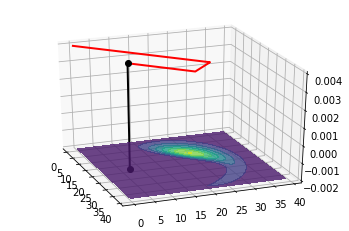

[[ 7. 20.]
 [ 8. 19.]
 [ 6. 20.]
 [ 7. 19.]
 [ 8. 18.]
 [ 7. 18.]
 [ 8. 20.]
 [ 6. 18.]
 [ 6. 19.]]
[0.9958781819313207, 0.9965435425750248, 0.9953212322671403, 0.9959842294240714, 0.9964985524178397, 0.9959592616954538, 0.9964648928733105, 0.9954435032715264, 0.9954472653404917]
1
normalization factor:  0.9953212322671403
iteration 43 [ 6. 20.]


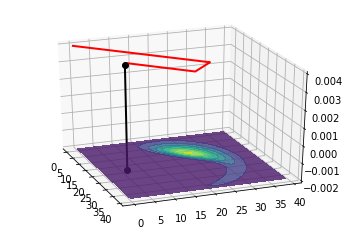

[[ 6. 21.]
 [ 5. 21.]
 [ 6. 19.]
 [ 6. 20.]
 [ 7. 19.]
 [ 7. 21.]
 [ 7. 20.]
 [ 5. 20.]
 [ 5. 19.]]
[0.9965542399307222, 0.9962728567913999, 0.9970334821378591, 0.99691770050788, 0.9973667745417029, 0.9969103630221253, 0.9972613306915994, 0.9966260777992083, 0.9967438622698169]
4
normalization factor:  0.9962728567913999
iteration 44 [ 5. 21.]


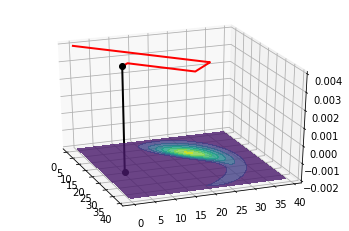

[[ 6. 20.]
 [ 5. 20.]
 [ 6. 21.]
 [ 5. 21.]
 [ 6. 22.]
 [ 5. 22.]
 [ 4. 21.]
 [ 4. 22.]
 [ 4. 20.]]
[0.9978739982667363, 0.9977159925188893, 0.9976024352897752, 0.9974615497124725, 0.9970231560319024, 0.996916680423294, 0.9973923781637629, 0.9969082484726338, 0.9976160354449211]
0
normalization factor:  0.9969082484726338
iteration 45 [ 4. 22.]


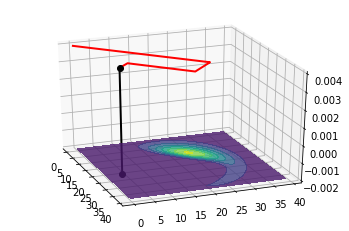

[[ 5. 22.]
 [ 5. 21.]
 [ 5. 23.]
 [ 3. 22.]
 [ 3. 21.]
 [ 4. 21.]
 [ 4. 22.]
 [ 4. 23.]
 [ 3. 23.]]
[0.9978179102763458, 0.9982240327713013, 0.9970975228687403, 0.9980003616503116, 0.9982793858174267, 0.9982253956817421, 0.9978784262587465, 0.997254032728293, 0.9974870025705694]
4
normalization factor:  0.9970975228687403
iteration 46 [ 5. 23.]


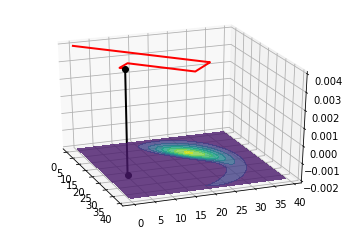

[[ 4. 22.]
 [ 6. 22.]
 [ 4. 24.]
 [ 4. 23.]
 [ 6. 23.]
 [ 5. 23.]
 [ 5. 24.]
 [ 5. 22.]
 [ 6. 24.]]
[0.9984759113664897, 0.9983827086916753, 0.9972956197804266, 0.998019647695595, 0.9977762207534343, 0.9978745782634276, 0.9970225356083893, 0.998414788669823, 0.9968205712920344]
0
normalization factor:  0.9968205712920344
iteration 47 [ 6. 24.]


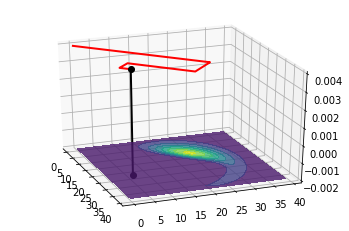

[[ 6. 23.]
 [ 5. 24.]
 [ 7. 24.]
 [ 5. 25.]
 [ 6. 25.]
 [ 7. 25.]
 [ 5. 23.]
 [ 6. 24.]
 [ 7. 23.]]
[0.9983845781001665, 0.997826390844103, 0.9975332990200203, 0.9968931431801246, 0.9965860624735565, 0.9963608027370067, 0.9984657497226606, 0.9976554741580599, 0.9983262821794976]
6
normalization factor:  0.9963608027370067
iteration 48 [ 7. 25.]


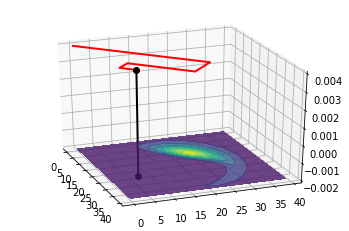

[[ 7. 24.]
 [ 7. 26.]
 [ 8. 24.]
 [ 6. 26.]
 [ 6. 25.]
 [ 8. 25.]
 [ 7. 25.]
 [ 8. 26.]
 [ 6. 24.]]
[0.9982388694807187, 0.9960774253695522, 0.9981695018758762, 0.996397415391195, 0.9975243677112149, 0.9972163826227735, 0.9973414244460277, 0.9958554721315446, 0.9983339538014272]
8
normalization factor:  0.9958554721315446
iteration 49 [ 8. 26.]


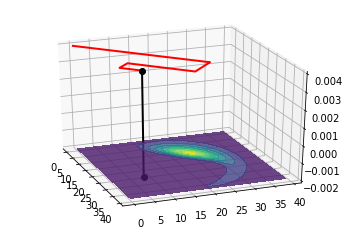

[[ 9. 27.]
 [ 7. 25.]
 [ 7. 26.]
 [ 8. 26.]
 [ 9. 25.]
 [ 8. 25.]
 [ 8. 27.]
 [ 7. 27.]
 [ 9. 26.]]
[0.9953806195902851, 0.9981397133224276, 0.9971823434944526, 0.9970064287745408, 0.9979817955964977, 0.9980451473113773, 0.9955777563635454, 0.9958866578529392, 0.9968977327476992]
1
normalization factor:  0.9953806195902851
iteration 50 [ 9. 27.]


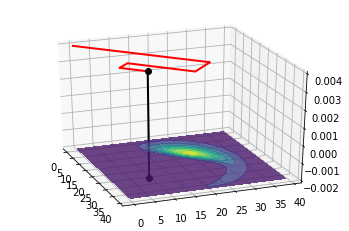

[[10. 26.]
 [ 9. 26.]
 [ 8. 27.]
 [ 8. 26.]
 [ 9. 28.]
 [ 8. 28.]
 [ 9. 27.]
 [10. 27.]
 [10. 28.]]
[0.9978005704338879, 0.997846137013583, 0.9968464926997933, 0.9979262485503734, 0.9951306178988276, 0.9954118417309692, 0.9966927261724484, 0.9966101027574987, 0.9949655845516588]
3
normalization factor:  0.9949655845516588
iteration 51 [10. 28.]


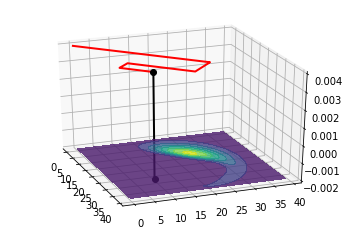

[[11. 29.]
 [11. 27.]
 [11. 28.]
 [10. 29.]
 [ 9. 28.]
 [10. 28.]
 [ 9. 29.]
 [ 9. 27.]
 [10. 27.]]
[0.9945969640085546, 0.9976326827218608, 0.9963495686500903, 0.9947448605927663, 0.996540891906886, 0.9964128110580079, 0.9949979690898595, 0.9977191902089421, 0.9976600219822601]
7
normalization factor:  0.9945969640085546
iteration 52 [11. 29.]


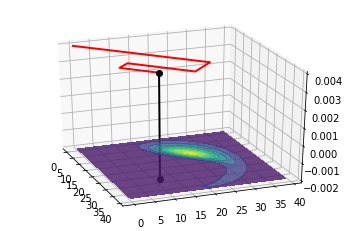

[[12. 30.]
 [10. 28.]
 [11. 28.]
 [10. 30.]
 [12. 29.]
 [10. 29.]
 [12. 28.]
 [11. 30.]
 [11. 29.]]
[0.9942277130548507, 0.997526224152828, 0.9974814708257462, 0.9946486034665574, 0.996079566797221, 0.996269476597715, 0.9974556846821547, 0.9944017214304626, 0.9961529173971991]
1
normalization factor:  0.9942277130548507
iteration 53 [12. 30.]


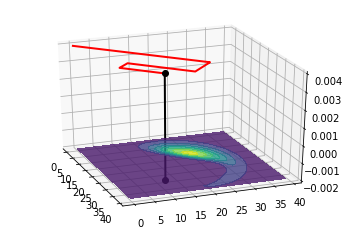

[[11. 30.]
 [12. 29.]
 [13. 31.]
 [12. 31.]
 [13. 29.]
 [13. 30.]
 [12. 30.]
 [11. 29.]
 [11. 31.]]
[0.9960230941213185, 0.9972857113609418, 0.9937976225618437, 0.9940714097949291, 0.9972211841644097, 0.9957408183829913, 0.9958820041008372, 0.9973404642214929, 0.9943582522186294]
7
normalization factor:  0.9937976225618437
iteration 54 [13. 31.]


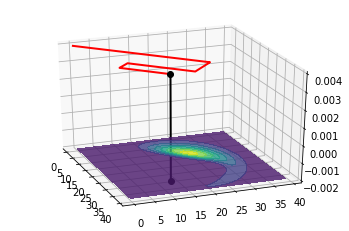

[[12. 31.]
 [13. 32.]
 [14. 30.]
 [12. 32.]
 [14. 32.]
 [13. 30.]
 [13. 31.]
 [12. 30.]
 [14. 31.]]
[0.995793409842985, 0.9937415600784179, 0.9968638459760484, 0.994133813221575, 0.9932701476174698, 0.9970372887004477, 0.995569370150325, 0.9971481472501313, 0.9952728377460054]
7
normalization factor:  0.9932701476174698
iteration 55 [14. 32.]


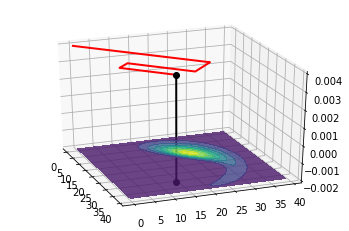

[[14. 31.]
 [15. 33.]
 [14. 32.]
 [15. 32.]
 [13. 32.]
 [13. 33.]
 [13. 31.]
 [14. 33.]
 [15. 31.]]
[0.9967074882744885, 0.9926840195948569, 0.9952132346226528, 0.9946537330771201, 0.995593695004307, 0.9940202249806945, 0.9969420408646195, 0.9934535630246975, 0.996324559048562]
6
normalization factor:  0.9926840195948569
iteration 56 [15. 33.]


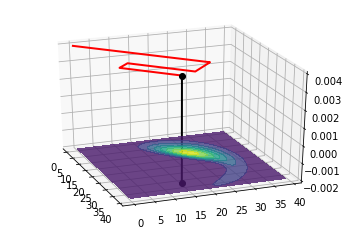

[[16. 32.]
 [14. 33.]
 [15. 33.]
 [14. 32.]
 [14. 34.]
 [16. 33.]
 [16. 34.]
 [15. 34.]
 [15. 32.]]
[0.9955942438948634, 0.995478124945106, 0.9948723518731529, 0.9967393343068254, 0.9941113172801183, 0.9939514527148162, 0.9921931017397737, 0.993324603300942, 0.99630204502942]
3
normalization factor:  0.9921931017397737
iteration 57 [16. 34.]


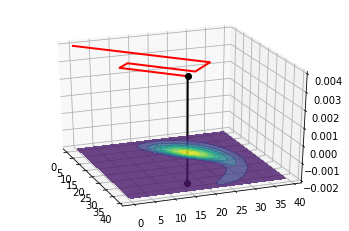

[[16. 34.]
 [15. 35.]
 [15. 33.]
 [16. 35.]
 [17. 35.]
 [16. 33.]
 [15. 34.]
 [17. 34.]
 [17. 33.]]
[0.9946687846014813, 0.994512412694596, 0.9965907785509381, 0.9935115292728202, 0.9920344694734058, 0.995883877772457, 0.9955345900190077, 0.9933435709530655, 0.9947594336924908]
2
normalization factor:  0.9920344694734058
iteration 58 [17. 35.]


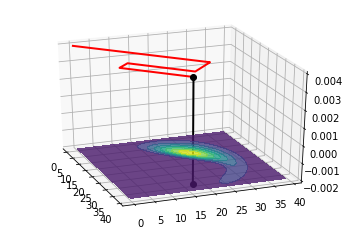

[[17. 35.]
 [18. 35.]
 [16. 36.]
 [16. 35.]
 [18. 36.]
 [17. 34.]
 [16. 34.]
 [18. 34.]
 [17. 36.]]
[0.9947240498400419, 0.9930470009011134, 0.9952451148408911, 0.9958259982262212, 0.9923894192646697, 0.9955557132089589, 0.9965565735799089, 0.9939964885942663, 0.9940973313703719]
6
normalization factor:  0.9923894192646697
iteration 59 [18. 36.]


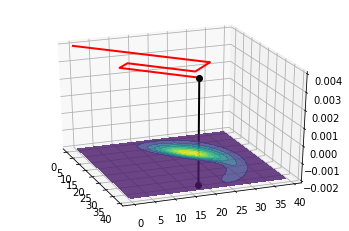

[[17. 36.]
 [18. 36.]
 [17. 37.]
 [19. 35.]
 [18. 35.]
 [19. 36.]
 [18. 37.]
 [17. 35.]
 [19. 37.]]
[0.9963135014964855, 0.9950588462116365, 0.9961732431049625, 0.9934875705115815, 0.9953945481080014, 0.9931800224809346, 0.994987263093803, 0.9966513774208485, 0.9932326749182453]
7
normalization factor:  0.9931800224809346
iteration 60 [19. 36.]


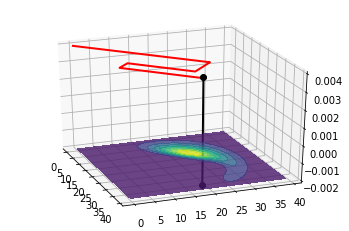

[[20. 36.]
 [18. 36.]
 [18. 35.]
 [19. 37.]
 [19. 36.]
 [18. 37.]
 [20. 37.]
 [19. 35.]
 [20. 35.]]
[0.9932856881413304, 0.9967514046927679, 0.996914287102775, 0.9954605408096375, 0.9953435008333832, 0.9967516071973459, 0.9935898282998947, 0.9954552877476113, 0.993301214507609]
2
normalization factor:  0.9932856881413304
iteration 61 [20. 36.]


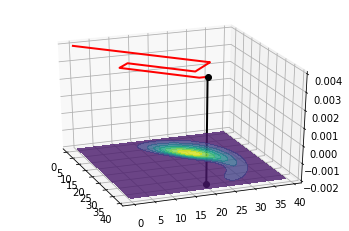

[[19. 35.]
 [19. 36.]
 [19. 37.]
 [20. 37.]
 [20. 36.]
 [21. 36.]
 [21. 35.]
 [20. 35.]
 [21. 37.]]
[0.9968810810907086, 0.9968729251284294, 0.9970027412604278, 0.9956160066128175, 0.995317952126661, 0.9931147129968896, 0.9928386651305589, 0.995217573935256, 0.9936662848456993]
2
normalization factor:  0.9928386651305589
iteration 62 [21. 35.]


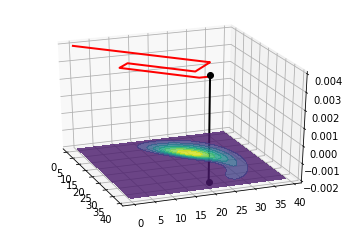

[[20. 35.]
 [22. 34.]
 [21. 35.]
 [22. 36.]
 [21. 36.]
 [21. 34.]
 [20. 34.]
 [20. 36.]
 [22. 35.]]
[0.9966838566811723, 0.9920765455969036, 0.9948570474777978, 0.9928375686964866, 0.9951197003297158, 0.994771548296149, 0.9966956710965145, 0.9967873224553814, 0.9923296819448321]
7
normalization factor:  0.9920765455969036
iteration 63 [22. 34.]


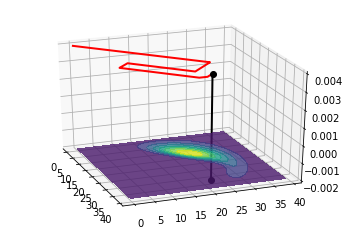

[[23. 35.]
 [22. 34.]
 [21. 34.]
 [21. 35.]
 [23. 33.]
 [22. 33.]
 [22. 35.]
 [23. 34.]
 [21. 33.]]
[0.9919060690213786, 0.9942546160741136, 0.9963382608723744, 0.9964209263834153, 0.9911605710496681, 0.9941648997263313, 0.9944889670972503, 0.9914282687812686, 0.9963459466680864]
3
normalization factor:  0.9911605710496681
iteration 64 [23. 33.]


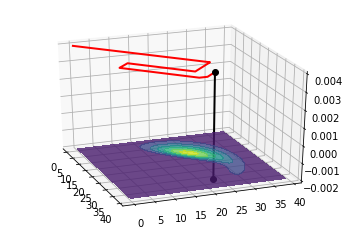

[[22. 34.]
 [22. 32.]
 [24. 32.]
 [24. 33.]
 [23. 34.]
 [23. 32.]
 [23. 33.]
 [22. 33.]
 [24. 34.]]
[0.9959722961628391, 0.9958574800677931, 0.9900712323670701, 0.990454937644376, 0.9938022141527212, 0.9934009913274389, 0.9935608828916246, 0.9958912346512308, 0.9909591232748206]
0
normalization factor:  0.9900712323670701
iteration 65 [24. 32.]


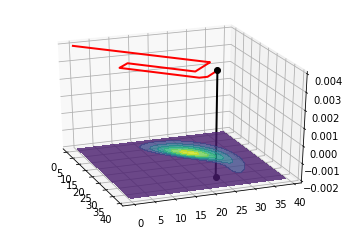

[[23. 33.]
 [23. 31.]
 [23. 32.]
 [25. 31.]
 [24. 31.]
 [25. 32.]
 [24. 33.]
 [24. 32.]
 [25. 33.]]
[0.9954595963831828, 0.9951513160463045, 0.9953219101680448, 0.988659591862978, 0.9923609132707778, 0.9893503461830495, 0.9930710439848219, 0.9927330644197163, 0.9900043355456722]
0
normalization factor:  0.988659591862978
iteration 66 [25. 31.]


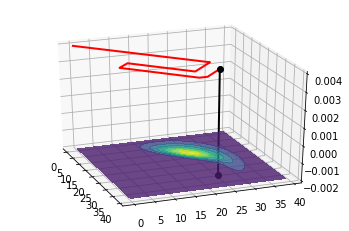

[[26. 31.]
 [25. 31.]
 [24. 31.]
 [24. 32.]
 [26. 30.]
 [26. 32.]
 [24. 30.]
 [25. 32.]
 [25. 30.]]
[0.9879915869750603, 0.9916525420109115, 0.9945337721085646, 0.9948496220104203, 0.9867019973502046, 0.9889942883807256, 0.9940390967420984, 0.9922505291388394, 0.9908231150964032]
3
normalization factor:  0.9867019973502046
iteration 67 [26. 30.]


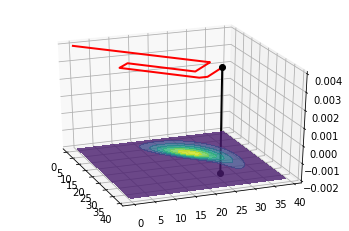

[[25. 30.]
 [26. 30.]
 [27. 30.]
 [27. 29.]
 [25. 31.]
 [26. 31.]
 [27. 31.]
 [26. 29.]
 [25. 29.]]
[0.9933675790313997, 0.9901678616955932, 0.9862685009174519, 0.9840138592797801, 0.9940656171493141, 0.9912663502349288, 0.9878754537690423, 0.9885268684122109, 0.992239763321055]
4
normalization factor:  0.9840138592797801
iteration 68 [27. 29.]


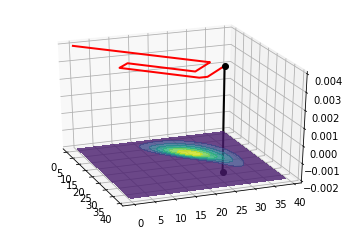

[[26. 30.]
 [27. 28.]
 [28. 29.]
 [28. 28.]
 [26. 28.]
 [27. 29.]
 [26. 29.]
 [28. 30.]
 [27. 30.]]
[0.993018348678174, 0.9853149185757066, 0.9841974757122809, 0.9806267230966194, 0.9894649108267857, 0.9881833851104239, 0.9916527264919469, 0.9866606746183462, 0.9900696045227477]
0
normalization factor:  0.9806267230966194
iteration 69 [28. 28.]


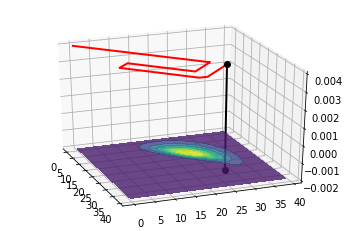

[[29. 29.]
 [28. 29.]
 [27. 27.]
 [28. 27.]
 [28. 28.]
 [29. 27.]
 [27. 28.]
 [29. 28.]
 [27. 29.]]
[0.985490091678262, 0.9887048976881327, 0.9855922266714988, 0.9813247932776665, 0.9857746280553966, 0.9769424590989394, 0.9893068023606206, 0.9820193742356279, 0.9916624704044257]
8
normalization factor:  0.9769424590989394
iteration 70 [29. 27.]


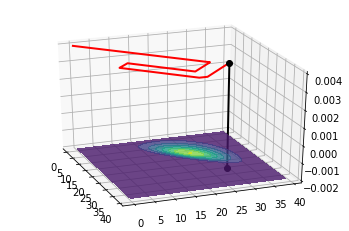

[[28. 27.]
 [28. 28.]
 [30. 28.]
 [30. 26.]
 [29. 28.]
 [30. 27.]
 [29. 26.]
 [28. 26.]
 [29. 27.]]
[0.9864415845758465, 0.9900525034398721, 0.9846210163407361, 0.973706219565993, 0.9873441560285295, 0.9801840894680598, 0.9770940397900628, 0.9808520024839966, 0.9832509807377529]
1
normalization factor:  0.973706219565993
iteration 71 [30. 26.]


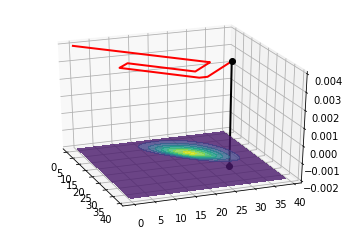

[[30. 26.]
 [30. 27.]
 [29. 27.]
 [30. 25.]
 [29. 26.]
 [31. 27.]
 [29. 25.]
 [31. 25.]
 [31. 26.]]
[0.9810854667534611, 0.9862421095460968, 0.9883548443476294, 0.9734418736201776, 0.9833935540894265, 0.9843246981617209, 0.9758779300890673, 0.9717334782839013, 0.9791815288435217]
2
normalization factor:  0.9717334782839013
iteration 72 [31. 25.]


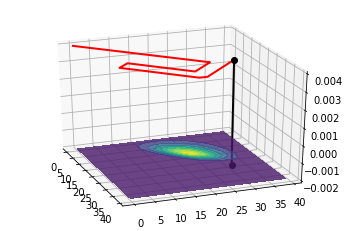

[[30. 24.]
 [30. 26.]
 [31. 25.]
 [32. 25.]
 [32. 26.]
 [31. 26.]
 [31. 24.]
 [32. 24.]
 [30. 25.]]
[0.9715510224861255, 0.9868053656750252, 0.9797400188741364, 0.9793249869184744, 0.9847589243886685, 0.9856371912573066, 0.9711666847134912, 0.9715564190493001, 0.9806449824503742]
1
normalization factor:  0.9711666847134912
iteration 73 [31. 24.]


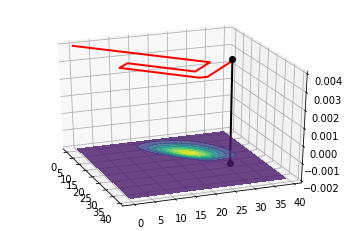

[[32. 24.]
 [32. 25.]
 [30. 23.]
 [30. 24.]
 [31. 23.]
 [32. 23.]
 [30. 25.]
 [31. 24.]
 [31. 25.]]
[0.9790846365383633, 0.9852195250660686, 0.9677782381076115, 0.9785111422376521, 0.968766997932872, 0.9704097507838157, 0.9859295819639944, 0.9785967006337812, 0.9854658736756743]
6
normalization factor:  0.9677782381076115
iteration 74 [30. 23.]


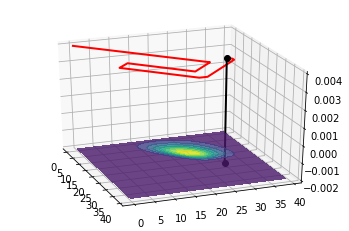

[[31. 22.]
 [29. 24.]
 [29. 22.]
 [29. 23.]
 [31. 23.]
 [30. 23.]
 [31. 24.]
 [30. 22.]
 [30. 24.]]
[0.9652427347852054, 0.9842776902154888, 0.9617999108169034, 0.9750106979512329, 0.9762573014989847, 0.9754053307070342, 0.984145796519037, 0.9631266196321424, 0.9841058559794624]
1
normalization factor:  0.9617999108169034
iteration 75 [29. 22.]


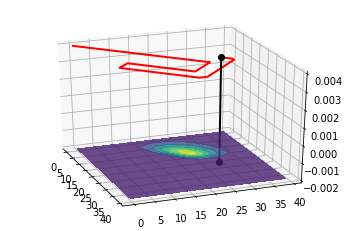

[[29. 21.]
 [28. 23.]
 [29. 23.]
 [29. 22.]
 [28. 21.]
 [30. 22.]
 [28. 22.]
 [30. 23.]
 [30. 21.]]
[0.9557794495121622, 0.9815446667490366, 0.9814801047070618, 0.9707287112944594, 0.9544530915861618, 0.9717757101909421, 0.970279742168599, 0.9817022499631918, 0.9581260867529074]
7
normalization factor:  0.9544530915861618
iteration 76 [28. 21.]


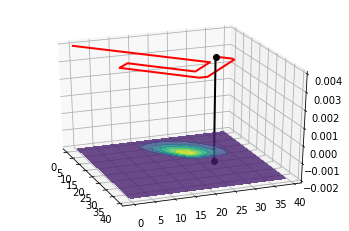

[[27. 21.]
 [28. 21.]
 [27. 22.]
 [28. 22.]
 [29. 22.]
 [29. 21.]
 [27. 20.]
 [28. 20.]
 [29. 20.]]
[0.9649491360269619, 0.9651632869550124, 0.9782307205612576, 0.9780586896976877, 0.9782720586909606, 0.9661386474665676, 0.9465344698008757, 0.9474760243511396, 0.9496931265087841]
4
normalization factor:  0.9465344698008757
iteration 77 [27. 20.]


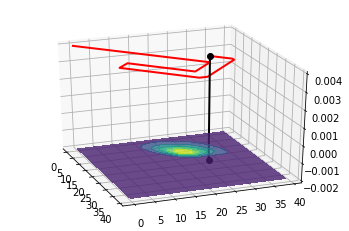

[[27. 19.]
 [27. 20.]
 [27. 21.]
 [26. 20.]
 [28. 20.]
 [28. 19.]
 [26. 21.]
 [28. 21.]
 [26. 19.]]
[0.9388583334075097, 0.9591913588065777, 0.9742049561935976, 0.959513294357217, 0.9597682035751447, 0.9405115625299911, 0.9747074890986608, 0.9741682377784401, 0.9387032123321652]
6
normalization factor:  0.9387032123321652
iteration 78 [26. 19.]


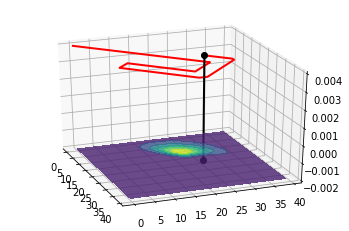

[[26. 19.]
 [27. 18.]
 [27. 19.]
 [26. 18.]
 [25. 20.]
 [27. 20.]
 [26. 20.]
 [25. 18.]
 [25. 19.]]
[0.9532611198168721, 0.9311652426948719, 0.9530846937379447, 0.9305432221743188, 0.9712888654533292, 0.9696911768984424, 0.9702414377618903, 0.9315610706201042, 0.9544102517818178]
4
normalization factor:  0.9305432221743188
iteration 79 [26. 18.]


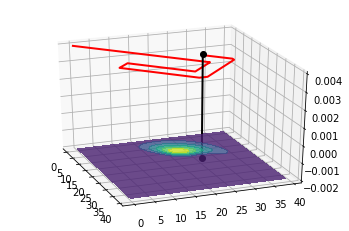

[[27. 18.]
 [26. 17.]
 [27. 19.]
 [26. 18.]
 [27. 17.]
 [26. 19.]
 [25. 17.]
 [25. 19.]
 [25. 18.]]
[0.9472869430879288, 0.9228681698152135, 0.9651498678097779, 0.9470727875778041, 0.9242967716721809, 0.965601415411339, 0.9227467987620049, 0.9663489999784137, 0.94757309546943]
7
normalization factor:  0.9227467987620049
iteration 80 [25. 17.]


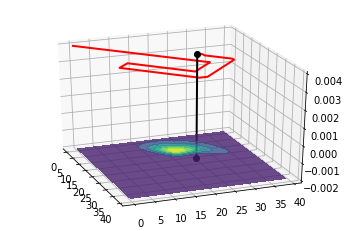

[[24. 16.]
 [26. 16.]
 [25. 16.]
 [24. 18.]
 [25. 17.]
 [24. 17.]
 [26. 17.]
 [25. 18.]
 [26. 18.]]
[0.9160509346578634, 0.9156680546467337, 0.9151741118258326, 0.9627236051530952, 0.941297129680521, 0.9424809808825757, 0.9408347741615813, 0.9615313063000721, 0.9606079435186142]
3
normalization factor:  0.9151741118258326
iteration 81 [25. 16.]


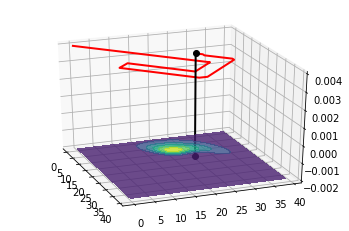

[[25. 17.]
 [24. 15.]
 [25. 15.]
 [26. 16.]
 [26. 17.]
 [24. 17.]
 [26. 15.]
 [24. 16.]
 [25. 16.]]
[0.9567702475504019, 0.9082420590391029, 0.9086418400909338, 0.9353099889748558, 0.9558331636467796, 0.9576043527331368, 0.9098460710879939, 0.9359002774686905, 0.9354749771473313]
5
normalization factor:  0.9082420590391029
iteration 82 [24. 15.]


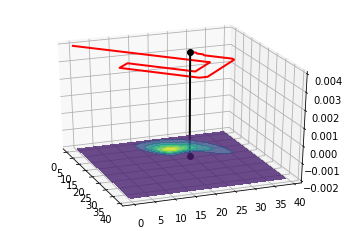

[[23. 15.]
 [23. 16.]
 [24. 14.]
 [25. 14.]
 [23. 14.]
 [25. 15.]
 [25. 16.]
 [24. 16.]
 [24. 15.]]
[0.9316742307110857, 0.954321988192536, 0.9028196583179, 0.9032496889488816, 0.9032185034045458, 0.9301064345298301, 0.9519783423329425, 0.9532261843696237, 0.9307702755214449]
1
normalization factor:  0.9028196583179
iteration 83 [24. 14.]


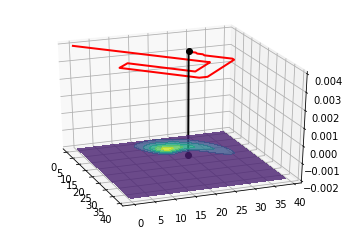

[[23. 14.]
 [25. 15.]
 [25. 13.]
 [24. 14.]
 [23. 13.]
 [23. 15.]
 [25. 14.]
 [24. 13.]
 [24. 15.]]
[0.9265854136083632, 0.9476125801028057, 0.8996196682897254, 0.9263971678943984, 0.8980471687929183, 0.9498640645441722, 0.9257645156134923, 0.8988222926487924, 0.9491000514003763]
5
normalization factor:  0.8980471687929183
iteration 84 [23. 13.]


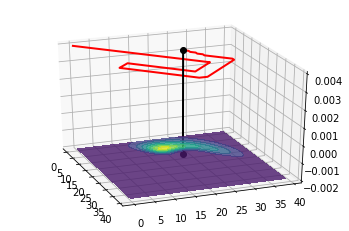

[[22. 14.]
 [24. 14.]
 [23. 14.]
 [22. 12.]
 [24. 12.]
 [23. 13.]
 [24. 13.]
 [23. 12.]
 [22. 13.]]
[0.9477081023020176, 0.9453941177752619, 0.9469260467210958, 0.8961857906312327, 0.8966007486722346, 0.9239316494102139, 0.9230546337607771, 0.8963732144228412, 0.9243571979347338]
0
normalization factor:  0.8961857906312327
iteration 85 [22. 12.]


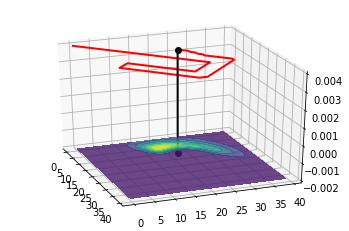

[[23. 12.]
 [21. 12.]
 [22. 13.]
 [23. 13.]
 [21. 11.]
 [22. 12.]
 [22. 11.]
 [23. 11.]
 [21. 13.]]
[0.9222880086285509, 0.9252977801606158, 0.9464817021718986, 0.944450833093132, 0.8986126960480956, 0.9240296942068271, 0.8974840351075128, 0.8963631247643238, 0.9477463319191981]
8
normalization factor:  0.8963631247643238
iteration 86 [23. 11.]


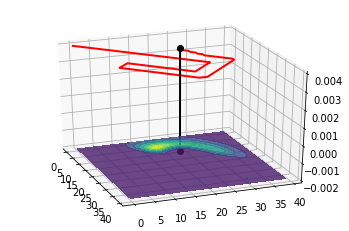

[[22. 12.]
 [24. 11.]
 [22. 11.]
 [23. 11.]
 [23. 10.]
 [22. 10.]
 [24. 10.]
 [23. 12.]
 [24. 12.]]
[0.9440923059813322, 0.9190738941839461, 0.9226032760768267, 0.9219335228461372, 0.8982801537219067, 0.8978822702116022, 0.8967992693152989, 0.9426816406987026, 0.9389729946483266]
0
normalization factor:  0.8967992693152989
iteration 87 [24. 10.]


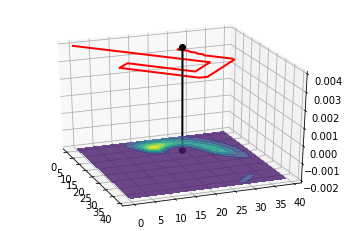

[[25. 11.]
 [24. 10.]
 [23.  9.]
 [23. 10.]
 [25. 10.]
 [24. 11.]
 [25.  9.]
 [24.  9.]
 [23. 11.]]
[0.9346163818141558, 0.9222087298619887, 0.9010456786883921, 0.9222965046825411, 0.918623818834661, 0.9398084388718619, 0.9014837100131924, 0.902890347998464, 0.9414535332117756]
8
normalization factor:  0.9010456786883921
iteration 88 [23.  9.]


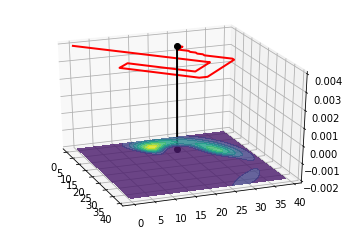

[[23.  9.]
 [22.  8.]
 [24. 10.]
 [22.  9.]
 [22. 10.]
 [24.  8.]
 [23. 10.]
 [24.  9.]
 [23.  8.]]
[0.9254711632990432, 0.9020200499668708, 0.9406499250995713, 0.9216441047297899, 0.9399508311806402, 0.9096693469774046, 0.9421314678521517, 0.9256723815833613, 0.9075360554741891]
6
normalization factor:  0.9020200499668708
iteration 89 [22.  8.]


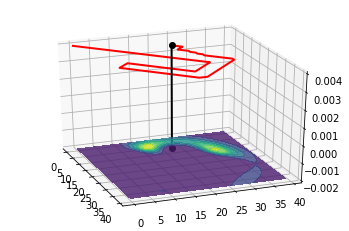

[[23.  7.]
 [23.  9.]
 [22.  8.]
 [22.  9.]
 [21.  7.]
 [21.  8.]
 [21.  9.]
 [22.  7.]
 [23.  8.]]
[0.9168085185892478, 0.9448096126979989, 0.9285597891865323, 0.9436296748749915, 0.9060061369850422, 0.9227953390546423, 0.9391781569565385, 0.9128913677699274, 0.9311098160235141]
1
normalization factor:  0.9060061369850422
iteration 90 [21.  7.]


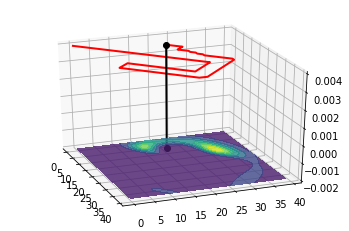

[[21.  7.]
 [22.  6.]
 [20.  7.]
 [20.  6.]
 [21.  8.]
 [22.  8.]
 [20.  8.]
 [21.  6.]
 [22.  7.]]
[0.9344026697207026, 0.9259428569431385, 0.9285174169954566, 0.9155921349687556, 0.9469282261508429, 0.9493940871982921, 0.9418180726059013, 0.9219597771437152, 0.9376957300045295]
5
normalization factor:  0.9155921349687556
iteration 91 [20.  6.]


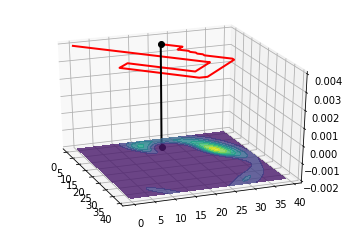

[[21.  7.]
 [21.  6.]
 [20.  5.]
 [19.  5.]
 [20.  6.]
 [19.  7.]
 [19.  6.]
 [21.  5.]
 [20.  7.]]
[0.9555493929188181, 0.9465777885823615, 0.9351462434469473, 0.9303526451189758, 0.9437616490191804, 0.9484613157805826, 0.9389544331084219, 0.938076914831565, 0.9530044499101719]
0
normalization factor:  0.9303526451189758
iteration 92 [19.  5.]


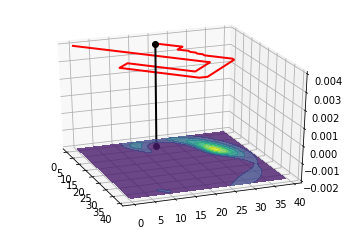

[[18.  4.]
 [19.  5.]
 [19.  4.]
 [20.  4.]
 [19.  6.]
 [20.  6.]
 [20.  5.]
 [18.  6.]
 [18.  5.]]
[0.9479291144372661, 0.9557317892655415, 0.9509425878219291, 0.9524786648750605, 0.961459899535994, 0.9633519409751508, 0.9574966837820234, 0.9581055970502799, 0.9524489240829128]
5
normalization factor:  0.9479291144372661
iteration 93 [18.  4.]


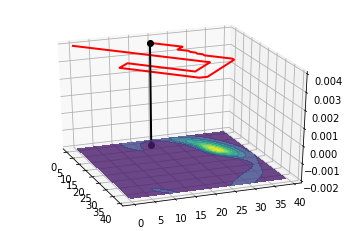

[[18.  4.]
 [17.  4.]
 [17.  3.]
 [19.  5.]
 [19.  3.]
 [17.  5.]
 [18.  3.]
 [18.  5.]
 [19.  4.]]
[0.968423274781238, 0.9665234276514956, 0.9651747482203294, 0.9720621430472897, 0.9671722920703568, 0.9689299190101545, 0.9667669009002039, 0.9710294632480031, 0.9691546528944263]
3
normalization factor:  0.9651747482203294
iteration 94 [17.  3.]


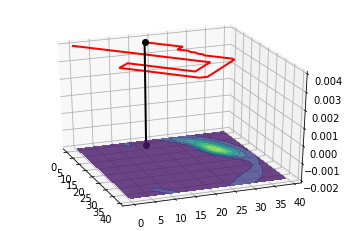

[[18.  3.]
 [16.  2.]
 [18.  4.]
 [16.  3.]
 [18.  2.]
 [17.  2.]
 [17.  3.]
 [17.  4.]
 [16.  4.]]
[0.9797633879908884, 0.9792949007633008, 0.9804598391986451, 0.9787815895425439, 0.9797933205490165, 0.9800021291494488, 0.9797140954947708, 0.9801210725519759, 0.9790076127475428]
2
normalization factor:  0.9787815895425439
iteration 95 [16.  3.]


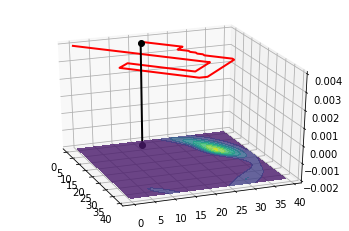

[[16.  2.]
 [15.  3.]
 [15.  2.]
 [16.  4.]
 [16.  3.]
 [17.  4.]
 [17.  3.]
 [17.  2.]
 [15.  4.]]
[0.9879590130507375, 0.9871214083846945, 0.9876214857235627, 0.9874372910483062, 0.9875504069310831, 0.9874907828143795, 0.9874265631694971, 0.9876761900136911, 0.986954562961595]
0
normalization factor:  0.986954562961595
iteration 96 [15.  4.]


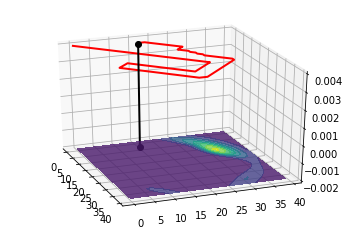

[[14.  5.]
 [14.  3.]
 [16.  4.]
 [16.  3.]
 [14.  4.]
 [15.  3.]
 [16.  5.]
 [15.  4.]
 [15.  5.]]
[0.9922735130296462, 0.9922381555749666, 0.9921570532922633, 0.9921418418940583, 0.9922334639569769, 0.9923528713809415, 0.9921648120315394, 0.9923149063192702, 0.9922845588273544]
5
normalization factor:  0.9921418418940583
iteration 97 [16.  3.]


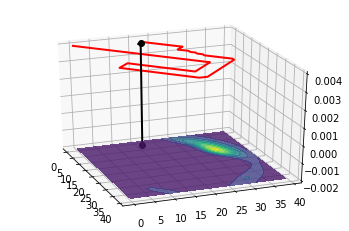

[[15.  2.]
 [17.  2.]
 [15.  4.]
 [16.  2.]
 [17.  4.]
 [16.  4.]
 [17.  3.]
 [15.  3.]
 [16.  3.]]
[0.9949144691982247, 0.993403931326898, 0.9946017871291627, 0.9945296680577635, 0.993399527394436, 0.9943018742293303, 0.993346218837516, 0.9947400072134809, 0.9943922916926936]
0
normalization factor:  0.993346218837516
iteration 98 [17.  3.]


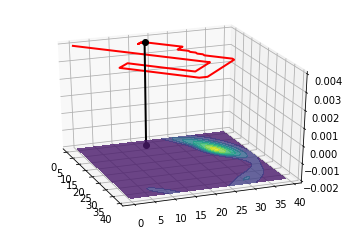

[[17.  3.]
 [17.  4.]
 [16.  2.]
 [16.  4.]
 [18.  4.]
 [17.  2.]
 [18.  2.]
 [16.  3.]
 [18.  3.]]
[0.9946964041264352, 0.9946655051392994, 0.9958116578624197, 0.9955092139740445, 0.9928903909768224, 0.9947975484393239, 0.9927575760443258, 0.9956543018561526, 0.9927272301025243]
2
normalization factor:  0.9927272301025243
iteration 99 [18.  3.]


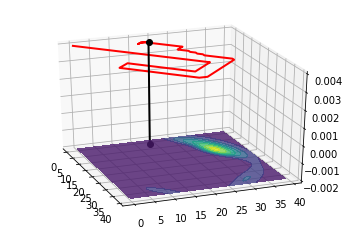

In [7]:
# Initialize variables and parameters
print('-------------------------------------------------\n');
print('> One agent search 2D (greedy 1-step ahead)\n')

# Initialize Agent
agent_state = [0,0]
delta = 1.0
possible_moves = np.array([[-delta, -delta], [-delta, 0.], [-delta, delta], [0., -delta], [0., 0.], [0., delta], [delta, -delta], [delta, 0.], [delta, delta]])

# Initialize Prior belief
beliefs = np.zeros((40,40))
for i in range(width):
    for j in range(height):
        beliefs[i,j] = bivariate_gaussian([i,j], mu, Sigma)

# store the trajectory of the agent for plotting
trajectory = [agent_state]
        
#Write the function that makes the agent search the environmnet
def agent_search(agent_state, trajectory, belief, iterations):

    nite = iterations # Number of steps computed
    ite = 0  # Current iteration
    found = 0 # Not used in this code

    while (not found and ite < nite):
        # compute discrete forward states
        # compute utility function of the potential forward states brute force method
        # selection of action/state with max information gain
        move = next_best_state(possible_moves, agent_state, belief)
        
        # simulate agent movement
        agent_state = move
        inv = [agent_state[1], agent_state[0]]
        trajectory = np.append(trajectory, [inv], axis=0)
        
        # update belief with the new observation (non-detection)
        prior = belief 
        updated_belief = np.zeros((width,height))
        
        for i in range(len(updated_belief)):
            for j in range(len(updated_belief)):
                updated_belief[i,j] = prior[i,j] * sensor_pnd(Pdmax, dmax, sigma, agent_state, i, j)
        
        # normalize belief
        norm_factor = sum(sum(updated_belief))
        print('normalization factor: ', norm_factor)
        normalized_map = updated_belief/norm_factor
        belief = normalized_map
        
        print('iteration {}'.format(ite), agent_state)

        # plot belief and trajectory
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.contourf(X, Y, belief, zdir='z', offset=-0.002, alpha = 0.8, cmap=cm.viridis)
        ax.plot(trajectory[:, 0], trajectory[:, 1], np.ones(trajectory.shape[0]) * 0.004, 'r-', linewidth=2);
        ax.plot([trajectory[-1, 0], trajectory[-1, 0]], [trajectory[-1, 1], trajectory[-1, 1]], [0.004, -0.002], 'ko-', linewidth=2);

        # Adjust the limits, ticks and view angle
        ax.set_zlim(-0.002,0.004)
        ax.view_init(27, -21)

        plt.show()
        plt.pause(0.1) # animation not needed in the jupyter notebook

        # iteration count
        ite +=1

# execute the function agent_search
agent_search(agent_state, trajectory, beliefs, 100)